### Stock prediction (buy/Sell signal)

In [1]:
print('Installing TA...')
!pip install ta
print('Installing TA-Lib...')
#!pip install TA-Lib
!pip install pyti


Installing TA...
  Created wheel for ta: filename=ta-0.5.9-cp36-none-any.whl size=23417 sha256=758c6000e6625038edea78096d08a821cb24edf916a44a09c2fa9888d740d0b4
  Stored in directory: /root/.cache/pip/wheels/7e/6e/5a/6e484ebcabf884c1f1fcbca8d9e26385470f52dabbd2dd05ea
Successfully built ta
Installing TA-Lib...


### Import Python Packages

In [2]:
import datetime as dt
import ta
import pyti.directional_indicators  as ta_adx
import pyti.volume_adjusted_moving_average  as ta_vwap


import pandas_datareader.data as web
import numpy as np
import pandas as pd
#import plotly.plotly as py
#import plotly.graph_objs as go

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import seaborn as sns

from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook, show
from bokeh.transform import factor_cmap, factor_mark
from bokeh.layouts import column
from bokeh.models import HoverTool, ColumnDataSource, RangeTool, DatetimeTickFormatter

from sklearn.preprocessing import Normalizer, normalize, MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.metrics import categorical_accuracy
from keras.utils import to_categorical
import keras.backend as K

from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.optimizers import Adam
from keras.layers import BatchNormalization

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
 
%matplotlib inline


Using TensorFlow backend.


In [3]:
# Test GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

#### load stock data

In [7]:
#Upload QQQ file
from google.colab import drive
from google.colab import files
#uploaded = files.upload()
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
path = '/content/drive/My Drive/ts_data/'
file_nme = 'AlphaVantageDaily_adjusted_qqq.csv'
etf = pd.read_csv(path+file_nme, infer_datetime_format=True,  index_col=['timestamp'])
#etf = pd.read_csv(file_nme, infer_datetime_format=True,  index_col=['timestamp'])
etf.sort_index(inplace=True)
print('Start:', etf.index.min(), 'End:', etf.index.max())
etf.head(5)


Start: 1999-03-10 End: 2019-06-27


,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
timestamp,,,,,,,,
1999-03-10,102.3,102.3,100.60,102.1,44.9877,2616000,0.0,1.0
1999-03-11,102.9,103.5,100.60,102.6,45.2080,4844300,0.0,1.0
1999-03-12,102.3,102.3,99.31,100.1,44.1065,4371800,0.0,1.0
1999-03-15,100.9,103.1,99.81,103.0,45.3843,3184500,0.0,1.0
1999-03-16,103.4,104.3,102.30,103.9,45.7808,2452900,0.0,1.0


In [12]:
etf.describe().T

,count,mean,std,min,25%,50%,75%,max
open,5109.0,7.438699e+01,4.493983e+01,1.994000e+01,3.939000e+01,5.538000e+01,1.052900e+02,2.298000e+02
high,5109.0,7.501415e+01,4.524498e+01,2.053000e+01,3.968500e+01,5.587000e+01,1.059199e+02,2.329000e+02
low,5109.0,7.365319e+01,4.456079e+01,1.976000e+01,3.900000e+01,5.479000e+01,1.042100e+02,2.270000e+02
close,5109.0,7.437047e+01,4.495419e+01,2.006000e+01,3.935000e+01,5.538000e+01,1.051200e+02,2.300000e+02
adjusted_close,5109.0,6.647846e+01,4.246551e+01,1.767780e+01,3.507370e+01,4.896710e+01,9.014090e+01,1.906888e+02
volume,5109.0,6.996211e+07,5.292414e+07,1.097837e+06,3.017664e+07,6.009376e+07,9.444580e+07,6.165787e+08
dividend_amount,5109.0,2.142983e-03,2.436519e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.206000e-01
split_coefficient,5109.0,1.000196e+00,1.399046e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00


In [0]:
#Upload Rusell file

from google.colab import files
uploaded = files.upload()


Saving RUTx.csv to RUTx (1).csv


### Technical Analysis (TA) Indicators
https://technical-analysis-library-in-python.readthedocs.io/en/latest/

*
The library has implemented 31 indicators:

Volume


* Accumulation/Distribution Index (ADI)
* On-Balance Volume (OBV)
* Chaikin Money Flow (CMF)
* Force Index (FI)
* Ease of Movement (EoM, EMV)
* Volume-price Trend (VPT)
* Negative Volume Index (NVI)

Volatility
* Average True Range (ATR)
* Bollinger Bands (BB)
* Keltner Channel (KC)
* Donchian Channel (DC)

Trend
* Moving Average Convergence Divergence (MACD)
* Average Directional Movement Index (ADX)
* Vortex Indicator (VI)
* Trix (TRIX)
* Mass Index (MI)
* Commodity Channel Index (CCI)
* Detrended Price Oscillator (DPO)
* KST Oscillator (KST)
* Ichimoku Kinkō Hyō (Ichimoku)

Momentum
* Money Flow Index (MFI)
* Relative Strength Index (RSI)
* True strength index (TSI)
* Ultimate Oscillator (UO)
* Stochastic Oscillator (SR)
* Williams %R (WR)
* Awesome Oscillator (AO) 

Others
* Daily Return (DR)
* Daily Log Return (DLR)
* Cumulative Return (CR)






In [13]:

# Calculate TA features filling NaN values
etf_ta = ta.add_all_ta_features(etf, "open", "high", "low", "close", "volume", fillna=True)
etf_ta.head()


/usr/local/lib/python3.6/dist-packages/ta/trend.py:543: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:547: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-03-10,102.3,102.3,100.60,102.1,44.9877,2616000,0.0,1.0,2.000471e+06,2616000,0.764706,0.000000e+00,0.000000,0.000000,941456.902580,1000.000000,0.0,102.100000,102.100000,102.10,0.0,0.0,101.666667,101.666667,99.966667,0.0,0.0,102.1,102.1,1.0,1.0,0.000000,0.000000,0.000000,102.100000,102.100000,0.0,0.0,0.0,1.0,1.0,0.0,37.902822,1.000000,0.000000,-27.729528,372.856682,372.856682,0.000000,101.450,101.450,73.931609,73.496922,4.0,4.0,0.0,102.10,99.31,102.3,0.0,0.0,50.000000,50.0,100.000000,99.283912,88.235294,88.235294,-11.764706,0.0,102.1,0.0,37.285668,0.000000,0.000000
1999-03-11,102.9,103.5,100.60,102.6,45.2080,4844300,0.0,1.0,3.837964e+06,7460300,0.514452,2.422150e+06,35.918502,35.918502,999116.390347,1000.000000,0.0,102.850000,101.850000,102.35,0.0,0.0,101.950000,101.950000,99.650000,0.0,0.0,102.1,102.6,1.0,0.0,-0.039886,-0.007977,-0.031909,102.176923,102.137037,0.0,0.0,0.0,1.0,1.0,0.0,0.000956,2.109840,66.666667,-27.979528,376.218231,374.537456,1.680775,102.050,102.050,73.931609,73.496922,8.0,4.0,4.0,102.60,99.31,102.3,0.0,0.0,100.000000,50.0,100.000000,96.431992,68.965517,78.600406,-31.034483,0.0,102.6,0.0,0.489716,0.488521,0.489716
1999-03-12,102.3,102.3,99.31,100.1,44.1065,4371800,0.0,1.0,1.776346e+06,3088500,0.150129,5.147714e+05,-85.149138,-24.615318,-82802.030651,975.633528,0.0,103.760247,99.439753,101.60,0.0,0.0,101.490000,101.490000,98.960000,0.0,0.0,100.1,102.6,0.0,1.0,0.128749,0.019368,0.109381,101.857396,101.986145,0.0,0.0,0.0,1.0,1.0,0.0,-0.002272,3.285731,-100.000000,-27.229528,366.133584,371.736166,-5.602582,101.405,101.405,73.931609,73.496922,8.0,12.0,-4.0,102.30,99.31,102.3,0.0,1.0,15.662651,50.0,96.289015,89.448857,18.854415,58.685076,-81.145585,0.0,100.1,0.0,-2.436647,-2.466825,-1.958864
1999-03-15,100.9,103.1,99.81,103.0,45.3843,3184500,0.0,1.0,4.767259e+06,6273000,0.317466,1.760526e+06,67.153399,5.974255,-14267.099372,1003.898635,0.0,104.179350,99.720650,101.95,0.0,0.0,101.610000,101.610000,98.890000,0.0,0.0,100.1,103.0,1.0,0.0,0.028064,0.021107,0.006957,102.033182,102.061246,0.0,0.0,0.0,1.0,1.0,0.0,-0.002612,4.512567,46.153846,-27.579528,370.839752,371.512062,-0.672310,101.405,101.405,73.931609,73.496922,16.0,12.0,4.0,99.31,99.31,106.5,1.0,0.0,58.931311,50.0,94.393324,90.109471,88.066826,58.628919,-11.933174,0.0,103.0,0.0,2.897103,2.855930,0.881489
1999-03-16,103.4,104.3,102.30,103.9,45.7808,2452900,0.0,1.0,6.238999e+06,8725900,0.357137,1.824395e+06,150.434180,42.089236,113691.348554,1012.670565,0.0,104.871719,99.808281,102.34,0.0,0.0,101.988000,101.988000,99.412000,0.0,0.0,100.1,103.9,1.0,0.0,-0.122935,-0.007701,-0.115234,102.320384,102.197450,0.0,0.0,0.0,1.0,1.0,0.0,0.000723,5.657393,143.399090,-27.969528,376.083769,372.426404,3.657365,101.805,101.805,73.931609,73.496922,20.0,12.0,8.0,99.31,99.31,106.5,0.0,0.0,64.942539,50.0,93.225726,89.596424,91.983968,66.301736,-8.016032,0.0,103.9,0.0

In [17]:
# list of Technical Indicators
etf_ta.columns

Index(['open', 'high', 'low', 'close', 'adjusted_close', 'volume',
       'dividend_amount', 'split_coefficient', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbm', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch',
       'volatility_dchi', 'volatility_dcli', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_a',
       'trend_ichimoku_b', 'trend_visual_ichimoku_a',
       'trend_visual_ichimok

In [15]:
stats=[]
colidx=[]
colnme=['count','mean','std','min','25%','50%','75%','max']

for c in etf_ta.columns:
  if 'volume' in c:
    stats.append(list(etf_ta[c].describe().reset_index().values[:,1]))
    colidx.append(c)

pd.DataFrame(stats, index=colidx, columns=colnme)


,count,mean,std,min,25%,50%,75%,max
volume,5109.0,6.996211e+07,5.292414e+07,1.097837e+06,3.017664e+07,6.009376e+07,9.444580e+07,6.165787e+08
volume_adi,5109.0,5.165643e+09,5.061118e+09,-1.240145e+09,2.162499e+08,3.867149e+09,1.001591e+10,1.407889e+10
volume_obv,5109.0,4.176255e+09,2.800512e+09,-8.081542e+08,1.068050e+09,5.590199e+09,6.558958e+09,7.696211e+09
volume_cmf,5109.0,6.702142e-02,1.568019e-01,-4.059914e-01,-4.325356e-02,6.526701e-02,1.750808e-01,7.647059e-01
volume_fi,5109.0,-3.218873e+06,2.484970e+07,-2.744120e+08,-8.888865e+06,1.451707e+06,8.266572e+06,1.327438e+08
volume_em,5109.0,-3.327182e-01,8.576363e+01,-5.409501e+03,-3.889069e-01,4.018465e-02,5.973638e-01,6.146464e+02
volume_sma_em,5109.0,-3.097369e-01,2.268653e+01,-4.395856e+02,-1.208860e-01,2.983243e-02,2.231816e-01,1.158933e+02
volume_vpt,5109.0,-6.789457e+04,2.812874e+06,-4.270211e+07,-6.004662e+05,6.046156e+04,6.182668e+05,3.528664e+07
volume_nvi,5109.0,9.612381e+03,1.334988e+04,9.360175e+02,1.590082e+03,3.204424e+03,1.159772e+04,6.755032e+04


### Feature Engineering
- calculate the cross-over (buy or sell)

In [0]:
# Calculate cross--overs and 
# those that are trend related


def ama(close,window):

  alpha = 2/(window+1)
  
  # Calculate efficiency ratio

  diff_num = close.diff(window).abs()
  diff_den = close.diff(1).abs()
  eff_ratio = diff_num/diff_den.rolling(window).sum()

  ama = np.zeros((len(close)))
  
  scf = 2
  scs = 30
  
  #c = ((eff_ratio*(scf-scs)) + scs)^2
  
  
#  for i in range(len(close)):
#'''
#  if i == window:
#    ama[i] = (alpha * eff_ratio[i] * close[i] ) + ((1 - (alpha * eff_ratio[i])) * close[i-1])
#  else:
#    ama[i] = (alpha * eff_ratio[i] * close[i] ) + ((1 - (alpha * eff_ratio[i])) * ama[i-1])
#'''
  
  return ama


def feature_engineer(data, short, mid, long):
  
 
  # Calculate adaptive Moving average for short and long periods
  
 
  ema_s = data.adjusted_close.ewm(span=short).mean()
  ema_l = data.adjusted_close.ewm(span=long).mean()
  ema_m = data.adjusted_close.ewm(span=mid).mean()
  #ema_2s = ema_s.ewm(span=short).mean()
  
  # Calculate cross-over

  ema_ratio = ema_m/ema_l
  #ema_std = ema_ratio.rolling(short).std()
  ema_ratio_s = ema_s/ema_m
  
  
  # Calculate volume weighted price 
  
  #vwap = data.adjusted_close*data.volume
  #vwap5 = vwap.rolling(window=short).sum()/data.volume.rolling(window=short).sum()
  #vwap = ta_vwap.volume_adjusted_moving_average(data.close, data.volume, 14)
  
  adx = ta_adx.average_directional_index(data.close, data.high, data.low, 14)
  

  out=data.copy()
  

  #out['vwap'] = vwap5
 
  out['ema_s'] = ema_s
  out['ema_l'] = ema_l
  out['ema_m'] = ema_m
  out['adx'] = adx
  out['rsi'] = data.momentum_rsi.values
  
  out['ema_ratio'] = ema_ratio
  out['ema_ratio_s'] = ema_ratio_s
  
  return out[long:]
  


### Cross-Over Signals

In [20]:
etf_signal = feature_engineer(etf_ta, 5, 13, 48)
etf_signal.head(10)

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,...,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr,ema_s,ema_l,ema_m,adx,rsi,ema_ratio,ema_ratio_s
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-05-18,108.6,109.3,107.00,108.30,47.7196,4633900,0.0,1.0,3.035526e+07,-9296700,0.243719,-2.140273e+05,59.561061,2.382694,71070.214727,1264.416716,3.713050,112.387276,103.872724,108.1300,0.0,0.0,107.373333,107.373333,103.753333,0.0,0.0,104.40,113.2,0.0,0.0,-0.502106,-0.490417,-0.011689,107.954680,107.452574,11.009777,19.012943,20.068682,0.988615,...,-0.017078,0.063112,25.875629,16.322612,-1.2300,15.499170,27.086864,-11.587694,106.8475,105.8,106.6500,104.75,36.0,16.0,20.0,112.521847,97.88,112.521847,0.0,0.0,51.797013,50.235253,26.270449,62.756799,62.626263,55.630976,-37.373737,0.639853,105.152561,0.837989,-0.367985,-0.368664,6.072478,47.699731,47.228675,47.553943,11.099267,51.797013,1.006887,1.003066
1999-05-19,108.7,109.8,107.00,109.80,48.3805,3992800,0.0,1.0,3.434806e+07,-5303900,0.235957,6.721481e+05,17.531557,10.651646,38249.869141,1281.929413,3.621745,112.534645,104.075355,108.3050,0.0,0.0,107.630000,107.630000,104.360000,0.0,0.0,104.40,113.2,0.0,0.0,-0.612118,-0.514757,-0.097360,108.238576,107.626458,10.228177,18.949987,18.975542,1.038314,...,0.101533,0.065397,25.609332,35.823951,-3.1050,15.738079,22.190591,-6.452512,106.8475,105.8,106.6500,104.75,32.0,12.0,20.0,112.313410,97.88,112.313410,0.0,0.0,54.553484,58.367511,25.606373,65.452630,77.777778,69.023569,-22.222222,0.533971,105.209135,2.712816,1.385042,1.375538,7.541626,47.926654,47.282372,47.672076,10.297068,54.553484,1.008242,1.005340
1999-05-20,110.0,110.0,106.60,106.70,47.0146,2998600,0.0,1.0,3.152584e+07,-8302500,0.171970,-7.518245e+05,-11.338625,9.598904,-29357.988082,1245.736506,3.599571,112.444083,103.915917,108.1800,0.0,0.0,107.870000,107.870000,104.750000,0.0,0.0,104.40,113.2,0.0,0.0,-0.444040,-0.500614,0.056574,108.001872,107.557831,9.656718,17.689935,18.496068,1.049603,...,0.099206,0.063558,25.342446,-7.916021,0.2200,15.988030,18.890301,-2.902270,107.2725,105.8,106.7500,104.75,28.0,8.0,20.0,112.109142,97.88,112.109142,0.0,0.0,48.394230,52.125189,24.515030,58.280128,46.464646,62.289562,-53.535354,0.108382,105.239902,1.425856,-2.823315,-2.863937,4.505387,47.622636,47.269961,47.578115,9.726958,48.394230,1.006519,1.000936
1999-05-21,107.1,107.4,105.20,105.80,46.6180,5479300,0.0,1.0,2.903525e+07,-13781800,0.129820,-1.348902e+06,-80.302228,3.380831,-130877.078031,1245.736506,3.459614,112.172446,103.707554,107.9400,0.0,0.0,107.973333,107.973333,104.953333,0.0,0.0,104.40,113.2,0.0,0.0,-0.235501,-0.447591,0.212091,107.663122,107.427622,9.652265,16.906571,20.495017,0.992016,...,0.013972,0.057277,25.103421,-69.432684,-3.5400,13.981401,16.629947,-2.648546,107.2725,105.8,106.0750,104.75,24.0,4.0,20.0,111.908959,97.88,111.908959,0.0,0.0,46.744174,52.188402,23.385246,51.099003,37.373737,53.872054,-62.626263,0.068382,105.242498,-2.398524,-0.843486,-0.847064,3.623898,47.287757,47.239909,47.440910,9.768815,46.744174,1.004

In [21]:
etf_signal.describe().T

,count,mean,std,min,25%,50%,75%,max
open,5061.0,74.082439,45.041640,19.940000,39.300000,54.860000,104.810000,229.800000
high,5061.0,74.703439,45.344608,20.530000,39.590000,55.300000,105.570000,232.900000
low,5061.0,73.362536,44.669781,19.760000,38.900000,54.270000,103.960000,227.000000
close,5061.0,74.067665,45.057327,20.060000,39.300000,54.740000,104.780000,230.000000
adjusted_close,5061.0,66.664746,42.622854,17.677800,34.930400,49.350000,90.717400,190.688800
...,...,...,...,...,...,...,...,...
ema_m,5061.0,66.501807,42.394559,18.447665,34.915316,49.482167,90.754681,188.511547
adx,5061.0,24.032184,8.972192,7.105774,17.455173,22.136877,29.535757,56.824853
rsi,5061.0,53.716385,11.996315,18.605097,44.948797,54.078257,62.597696,85.394253
ema_ratio,5061.0,1.004167,0.036326,0.819359,0.990650,1.011374,1.025316,1.123615


### Trading Range Using ADX

In [23]:

def trading_range(data, tol):
  
  in_range = np.where(data.adx < 25, 1, 0)
  
  signal = np.where(data.ema_ratio - 1 > 0, 2, np.where(data.ema_ratio - 1 < 0, 1,0))
  
  out = pd.DataFrame()
  
  
  out['timestamp'] = data.index
  out['in_range'] = in_range
  out['signal'] = signal
  out['price'] = data.adjusted_close.values
  out['ema_s'] = data.ema_s.values
  out['ema_m'] = data.ema_m.values
  out['ema_l'] = data.ema_l.values
  out['ema_ratio'] = data.ema_ratio.values
  out['ema_ratio_s'] = data.ema_ratio_s.values
  out['adx'] = data.adx.values
  out['rsi'] = data.rsi.values
  out = out.set_index('timestamp', drop=True)
  
  return out

etf_range = trading_range(etf_signal, 0.001)
etf_range.groupby(['in_range','signal']).size()


in_range  signal
0         1          853
          2         1066
1         1          834
          2         2308
dtype: int64

In [24]:
etf_range.describe()

,in_range,signal,price,ema_s,ema_m,ema_l,ema_ratio,ema_ratio_s,adx,rsi
count,5061.000000,5061.000000,5061.000000,5061.000000,5061.000000,5061.000000,5061.000000,5061.000000,5061.000000,5061.000000
mean,0.620826,1.666667,66.664746,66.609941,66.501807,66.037569,1.004167,1.000937,24.032184,53.716385
std,0.485229,0.471451,42.622854,42.542621,42.394559,41.762260,0.036326,0.014759,8.972192,11.996315
min,0.000000,1.000000,17.677800,17.939409,18.447665,19.876714,0.819359,0.917872,7.105774,18.605097
25%,0.000000,1.000000,34.930400,34.965842,34.915316,34.583267,0.990650,0.994509,17.455173,44.948797
50%,1.000000,2.000000,49.350000,49.410442,49.482167,49.682726,1.011374,1.003181,22.136877,54.078257
75%,1.000000,2.000000,90.717400,90.772685,90.754681,88.605008,1.025316,1.009644,29.535757,62.597696
max,1.000000,2.000000,190.688800,189.738087,188.511547,182.625382,1.123615,1.068112,56.824853,85.394253


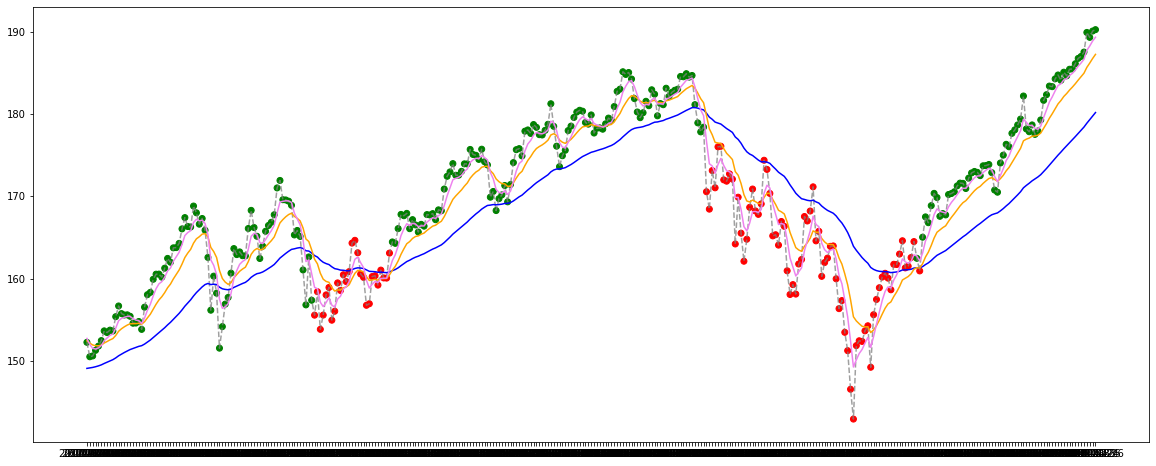

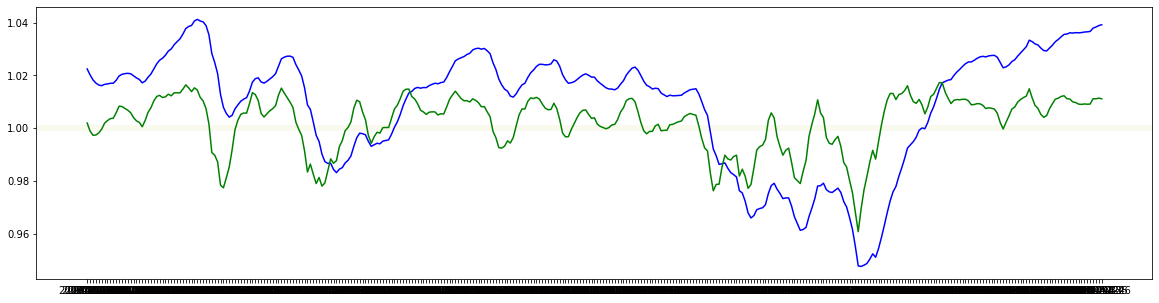

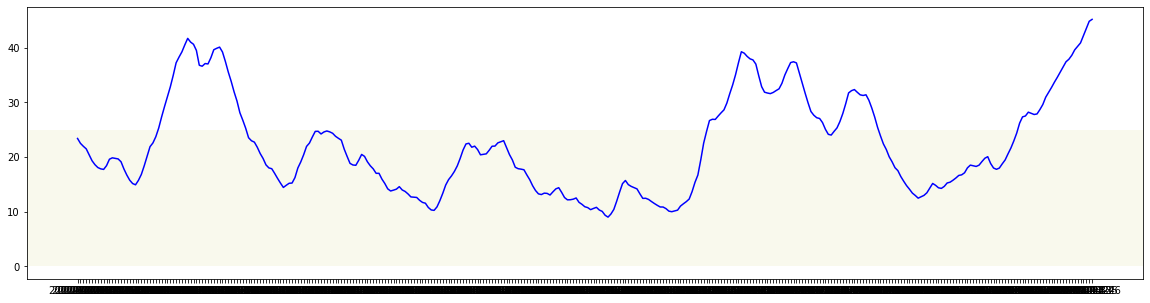

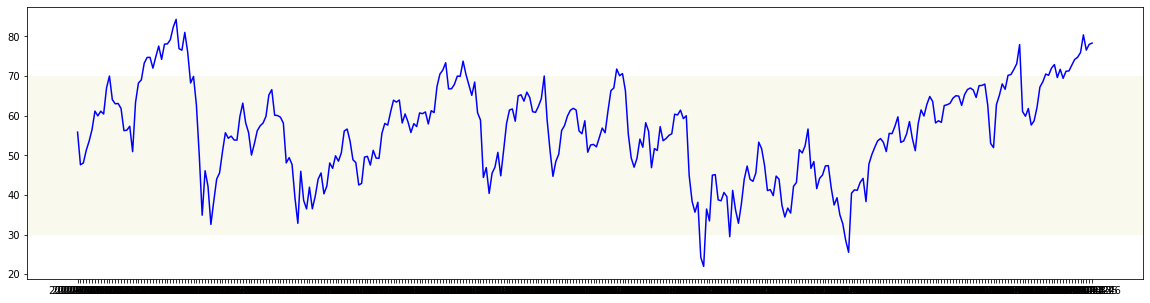

In [25]:

tol = 0.01

start = '2017-12-01'
end = '2019-04-27'

start_2 = '2016-08-30'
end_2 = '2017-12-30'


fig = plt.figure(figsize=(20,8))

signal = etf_range.signal[start:end]
in_range = etf_range.in_range[start:end]

#color = np.where((signal == 2) & (in_range == 0), 'g', np.where((signal == 1) & (in_range == 0), 'r', 'w'))
color = np.where((signal == 2), 'g', np.where((signal == 1), 'r', 'w'))
#marker = np.where(signal == 2, '^', np.where(signal == 1, 'o', '.'))

plt.plot(etf_range.price[start:end], color = 'grey', alpha = 0.75, ls ='--')
plt.plot(etf_range.ema_l[start:end], color = 'blue')
plt.plot(etf_range.ema_m[start:end], color = 'orange')
plt.plot(etf_range.ema_s[start:end], color = 'violet')


plt.scatter(etf_range[start:end].index, etf_range.price[start:end], marker = 'o', color=color)

fig = plt.figure(figsize=(20,5))

plt.plot(etf_range.ema_ratio[start:end], color = 'b')
plt.plot(etf_range.ema_ratio_s[start:end], color = 'g')
plt.axhspan(.999,1.001, facecolor = 'beige', alpha=0.5)


fig = plt.figure(figsize=(20,5))

plt.plot(etf_range.adx[start:end], color = 'b')
plt.axhspan(0,25, facecolor = 'beige', alpha=0.5)

fig = plt.figure(figsize=(20,5))

plt.plot(etf_range.rsi[start:end], color = 'b')
plt.axhspan(30,70, facecolor = 'beige', alpha=0.5)

### Cross Correlation Feature Selection

In [0]:
def norm_vector(v):
    '''
    normalized vector
    '''
    num=v-v.mean()
    den=np.sqrt(np.sum((v-v.mean())**2))
    return num/den

def norm_corr(x,y):
    '''
    calculate normalized cross-correlation
    '''
    norm_x = norm_vector(x)
    norm_y = norm_vector(y)
    return np.sum(norm_x*norm_y)
  
 


In [27]:

corr_hi = 0.4 
corr_lo = -0.4
corr_features = []

TA_group = [c for c in etf_signal.columns if 'trend' in c]
print('------------------------------------------------',"\n")    
for c in TA_group:
  corr = norm_corr(etf_signal[c], etf_signal['ema_ratio'])
  if (corr >= corr_hi)  or (corr <= corr_lo):
    corr_features.append(c)
    print(c,': ', corr)

TA_group = [c for c in etf_signal.columns if 'volume' in c]    
print('------------------------------------------------',"\n") 
for c in TA_group:
  corr = norm_corr(etf_signal[c], etf_signal['ema_ratio'])
  if (corr >= corr_hi)  or (corr <= corr_lo):
    corr_features.append(c)
    print(c,': ', corr)

TA_group = [c for c in etf_signal.columns if 'volatility' in c]    
print('------------------------------------------------',"\n") 
for c in TA_group:
  corr = norm_corr(etf_signal[c], etf_signal['ema_ratio'])
  if (corr >= corr_hi)  or (corr <= corr_lo):
    corr_features.append(c)
    print(c,': ', corr)

TA_group = [c for c in etf_signal.columns if 'momentum' in c]    
print('------------------------------------------------',"\n") 
for c in TA_group:
  corr = norm_corr(etf_signal[c], etf_signal['ema_ratio'])
  if (corr >= corr_hi)  or (corr <= corr_lo):
    corr_features.append(c)
    print(c,': ', corr)
    
TA_group = ['ema_m','ema_l', 'close', 'open', 'low','high', 'adjusted_close','others_dr', 'others_dlr', 'others_cr']    
print('------------------------------------------------',"\n") 
for c in TA_group:
  corr = norm_corr(etf_signal[c], etf_signal['ema_ratio'])
  if (corr >= corr_hi)  or (corr <= corr_lo):
    corr_features.append(c)
    print(c,': ', corr)


------------------------------------------------ 

trend_macd :  -0.4943505878035366
trend_macd_signal :  -0.5437862198642479
trend_adx_pos :  0.5843828912480192
trend_adx_neg :  -0.5221820888481521
trend_vortex_ind_pos :  0.5030962482353426
trend_vortex_ind_neg :  -0.5440801416691894
trend_vortex_ind_diff :  0.5367189981717573
trend_trix :  0.8382759811711381
trend_cci :  0.43971041089909024
trend_kst :  0.834489639465753
trend_kst_sig :  0.8353151383691045
trend_aroon_up :  0.6224565600613301
trend_aroon_down :  -0.5672820160662664
trend_aroon_ind :  0.659467893246834
------------------------------------------------ 

volume_cmf :  0.5304793876846525
------------------------------------------------ 

------------------------------------------------ 

momentum_rsi :  0.6342033722396445
momentum_mfi :  0.48208096332827505
momentum_tsi :  0.8241907668701278
momentum_stoch_signal :  0.4549308873035926
momentum_ao :  0.4143964127973442
momentum_roc :  0.4412502403792095
------------------

In [28]:


TA_group = [c for c in etf_signal.columns if 'momentum' in c]
print('------------------------------------------------',"\n")    
for c in TA_group:
  dtw, dist = distance, path = fastdtw(norm_vector(etf_signal[c]), norm_vector(etf_signal['ema_ratio']), dist=euclidean)
  print(c,': ', dtw)

------------------------------------------------ 

momentum_rsi :  32.18574622267976
momentum_mfi :  40.12381771747766
momentum_tsi :  17.47361046658271
momentum_uo :  45.67374935900937
momentum_stoch :  47.657939930181385
momentum_stoch_signal :  44.1159456766261
momentum_wr :  47.65793993018138
momentum_ao :  22.811008184660587
momentum_kama :  53.79185945516651
momentum_roc :  29.335843502511533


In [29]:
corr_features

['trend_macd',
 'trend_macd_signal',
 'trend_adx_pos',
 'trend_adx_neg',
 'trend_vortex_ind_pos',
 'trend_vortex_ind_neg',
 'trend_vortex_ind_diff',
 'trend_trix',
 'trend_cci',
 'trend_kst',
 'trend_kst_sig',
 'trend_aroon_up',
 'trend_aroon_down',
 'trend_aroon_ind',
 'volume_cmf',
 'momentum_rsi',
 'momentum_mfi',
 'momentum_tsi',
 'momentum_stoch_signal',
 'momentum_ao',
 'momentum_roc']

### Calculation of Y

In [0]:


def y_ma(data, tol):
  

  in_range = np.where(data.adx < 18, 1, tol)
  
  signal = np.where(data.ema_ratio - 1 > tol, 2, np.where(data.ema_ratio - 1 < 0, 1, tol))
  
  
  print('Identifying Signals: ')
  y = pd.DataFrame()
  
  y['timestamp'] = data.index
  
  #y['signal'] = np.where(signal == 0, 0,
  #                np.where((in_range == 0) & (signal == 1), 1,
  #                np.where((in_range == 0) & (signal == 2), 2, 0)))
  #                #np.where((in_range == 0) & (signal == 1), 3, 4))))
  
  y['signal'] = signal
  
  y.set_index('timestamp', drop=True)

  print(y.groupby('signal').size())
  
  return y


def y_return(dr, signal, threshold):
  
  print('Calculating Return: ')
  
  signal = np.where(dr - 1 > threshold, 2, np.where(dr - 1 < 0, 1, 0))
  
  y = pd.DataFrame()
 
  y['signal'] = signal

  print(y.groupby('signal').size())
  
  return y



def y_ratio(data):
  
  return data['ema_ratio']


###  Split Data

In [0]:

def split_data(data, sr):
  
  # sr = sampling rate    
  
  cut = np.int(sr*len(data))
  
  test = data[cut:].copy()
  train = data[:cut].copy()
  
  print('\n','Data Splits:')
  print('Train Samples:', train.shape)
  print('Test Samples:', test.shape)
      
  return train, test 
  

In [32]:
# Create Y and Split X for Training
# After split, Standardization and PCA will be applied to Training Data Set
# Standardization and PCAs will be saved later to be applied to Validation and Test

sr = 0.8
short = 5
mid = 13
long = 48

# Create X

etf_x = feature_engineer(etf_ta, short, mid, long)

# Create Y

etf_y = y_ratio(etf_x)
#etf_y = y_ma(etf_x, 0.02)
 
print('\n','X/Y:', etf_x.shape, etf_y.shape)


train_x, test_x = split_data(etf_x, sr)
train_y, test_y = split_data(etf_y, sr)



 X/Y: (5061, 81) (5061,)

 Data Splits:
Train Samples: (4048, 81)
Test Samples: (1013, 81)

 Data Splits:
Train Samples: (4048,)
Test Samples: (1013,)


In [33]:
etf_x.columns

Index(['open', 'high', 'low', 'close', 'adjusted_close', 'volume',
       'dividend_amount', 'split_coefficient', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbm', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch',
       'volatility_dchi', 'volatility_dcli', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_a',
       'trend_ichimoku_b', 'trend_visual_ichimoku_a',
       'trend_visual_ichimok

### Feature Selection via PCA

In [0]:

# Standardize Data


def data_standard(data, TAgroup):  
    
  x_scaler = StandardScaler().fit(train_x[TAgroup])
  x_scaled = x_scaler.fit_transform(data[TAgroup])
  
  return x_scaled


# Fit PCA per TA group

def data_pca(TAgroup, var_cut):
  
  x_pca=PCA().fit(train_x[TAgroup])
  
  variance = 0
  count = 0
  
  for value in x_pca.explained_variance_ratio_ :
    
    if variance < var_cut:
        variance += value
        count += 1
  
  #print(variance, count)
  return x_pca, count


# Extract PCAs per TA group


def pca_select(data, var_cut):
  
  Volume = ['volume_adi', 'volume_obv','volume_cmf', 'volume_fi','volume_em', 'volume_vpt', 'volume_nvi']
  Price = ['open', 'high', 'low', 'close', 'adjusted_close', 'vwap', 'ema_m', 'ema_l']
  Volatility = ['volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_kcc','volatility_kch', 'volatility_kcl', 'volatility_dch', 'volatility_dcl']
  Trend = ['adx', 'trend_macd', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx', 'trend_trix','trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst']
  Momentum = ['momentum_rsi', 'momentum_mfi', 'momentum_tsi','momentum_uo', 'momentum_stoch', 'momentum_wr','momentum_ao']
  Returns = ['others_dr', 'others_dlr', 'others_cr']
  Others = ['dividend_amount', 'split_coefficient','volume','ema_ratio']
  #Crossover = ['cross_5_20', 'cross_20_50', 'cross_14_48']
  
  TAgroups = [Price, Volume, Returns, Volatility, Trend, Momentum, Others]

  for i,g in enumerate(TAgroups):
    
    x_scaled = data_standard(data, g)  
    x_pca, x_cnt = data_pca(g, var_cut)  
    x_out = x_pca.fit_transform(x_scaled)   
    
    if i == 0:
      
      x_std = x_out[:, :x_cnt]
      
    else:
      
      x_std = np.concatenate([x_std, x_out[:, :x_cnt]], axis=1)
      
    print(g, x_cnt)

  print('PCA-Tansformed: ', x_std.shape)

  return x_std



In [36]:
# PCA transformation X features
#----------------------------------------------

corr_features = ['trend_macd',
 'trend_macd_signal',
 'trend_vortex_ind_pos',
 'trend_vortex_ind_neg',
 'trend_trix',
 'trend_cci',
 'trend_kst',
 'trend_kst_sig',
 'trend_aroon_up',
 'trend_aroon_down',
 'trend_aroon_ind',
 'volume_cmf',
 'momentum_rsi',
 'momentum_mfi',
 'momentum_tsi',
 'momentum_stoch_signal',
 'momentum_ao']

select_features = corr_features+['adx']

print('\n','Training:')
#train_x_std = pca_select(train_x, 1)
train_x_std = data_standard(train_x, select_features)
print(train_x_std.shape)

print('\n','Test:')
#test_x_std = pca_select(test_x, 1)
test_x_std = data_standard(test_x, select_features)
print(test_x_std.shape)



 Training:
(4048, 18)

 Test:
(1013, 18)


### Sub-sequences

In [0]:

def create_sequence(x, y, lookback, window, start):

  xseq = []
  yseq = []
  xidx = []
  yidx = []
  

  for i in range(lookback, x.shape[0]):

    if i+ lookback < x.shape[0]:

      xseq.append(np.array(x[i-lookback:i]))
      xidx.append(i+start)
      
      #yseq.append(np.array(y[(i+1):(i+window+1)]))
      yseq.append(np.array(y.iloc[window+i]))
      yidx.append(window+i+start)

  print('\n','Created Sequences: length = ', len(xseq))
  
  return np.array(xseq), np.array(yseq), xidx, yidx


def build_model_data(x, y, lookback, window, start):
  
  xs, ys, ix, iy = create_sequence(x, y, lookback, window, start)
  #ys = to_categorical(ys) 
  
  ys = ys.reshape(len(ys))
  xs = xs.reshape(len(xs), lookback, xs.shape[2])
  
  print('\n','Sequence Data:', xs.shape, ys.shape)
  
  return xs, ys, ix, iy



In [38]:

# Build Data for Model Training
# =====================================


window = 3
lookback = 14


# Create Data for Model Training
print('Training:')
train_x_seq, train_y_seq, train_x_idx, train_y_idx = build_model_data(train_x_std, train_y, lookback, window, 0)

print()
print('Test:')
test_x_seq, test_y_seq, test_x_idx, test_y_idx = build_model_data(test_x_std, test_y, lookback, window, len(train_x))


# loss function - penalizes loss when signs are opposite
# https://codeburst.io/neural-networks-for-algorithmic-trading-volatility-forecasting-and-custom-loss-functions-c030e316ea7e


def mae_loss(y_true, y_pred):
    alpha = 100.
    loss = K.switch(K.less(y_true * y_pred, 0), \
        alpha*y_pred**2 - K.sign(y_true)*y_pred + K.abs(y_true), \
        K.abs(y_true - y_pred)
        )
    return K.mean(loss, axis=-1)
  

Training:

 Created Sequences: length =  4020

 Sequence Data: (4020, 14, 18) (4020,)

Test:

 Created Sequences: length =  985

 Sequence Data: (985, 14, 18) (985,)


### Model Building -  Cross Ratios

In [39]:
print(train_x_idx[:5], train_y_idx[:5])
print(test_x_idx[:5], test_y_idx[:5], test_y_seq[:5], test_y[:5])

[14, 15, 16, 17, 18] [17, 18, 19, 20, 21]
[4062, 4063, 4064, 4065, 4066] [4065, 4066, 4067, 4068, 4069] [1.00077049 1.00382806 1.00785481 1.01146904 1.01429474] timestamp
2015-06-19    1.005655
2015-06-22    1.006824
2015-06-23    1.007827
2015-06-24    1.008072
2015-06-25    1.008019
Name: ema_ratio, dtype: float64


In [40]:
print(train_x_idx[1], train_y_idx[1])
print(test_x_idx[1], test_y_idx[1])

15 18
4063 4066


### Model Building - LSTM CNN

In [41]:
# Build the model
# Time distributed CNN + LSTM


from numpy.random import seed
seed(2019)

from tensorflow import set_random_seed
set_random_seed(201907)


window = 3
dr = 0.2
adam = Adam(lr=0.0001)

n_features = train_x_seq.shape[2]
n_timesteps = train_x_seq.shape[1]
n_seqs = 2
n_steps = np.int(n_timesteps/n_seqs)

neurons = 64

# define model

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=neurons, kernel_size=3, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(Conv1D(filters=neurons, kernel_size=3, activation='relu')))
#model.add(Dropout(dr))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(neurons, return_sequences=False))
#model.add(Dropout(dr))
#model.add(LSTM(36))
#model.add(Dropout(dr))
#model.add(BatchNormalization())
model.add(Dense(1))
model.compile(optimizer=adam, loss=mae_loss)
print(model.summary())

# fit LSTM network

n_epochs = 30
n_batch = 32

train_x_subseq = train_x_seq.reshape((train_x_seq.shape[0], n_seqs, n_steps, n_features))
test_x_subseq = test_x_seq.reshape((test_x_seq.shape[0], n_seqs, n_steps, n_features))

epoch_history = model.fit(train_x_subseq, train_y_seq, epochs=n_epochs, batch_size=n_batch, validation_data=(test_x_subseq, test_y_seq), verbose=2, shuffle=False)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 5, 64)       3520      
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 3, 64)       12352     
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 48,961


[[219  34 134]
 [  2   2  40]
 [ 13  15 526]]
              precision    recall  f1-score   support

 Below Cross       0.94      0.57      0.71       387
       Cross       0.04      0.05      0.04        44
 Above Cross       0.75      0.95      0.84       554

    accuracy                           0.76       985
   macro avg       0.58      0.52      0.53       985
weighted avg       0.79      0.76      0.75       985



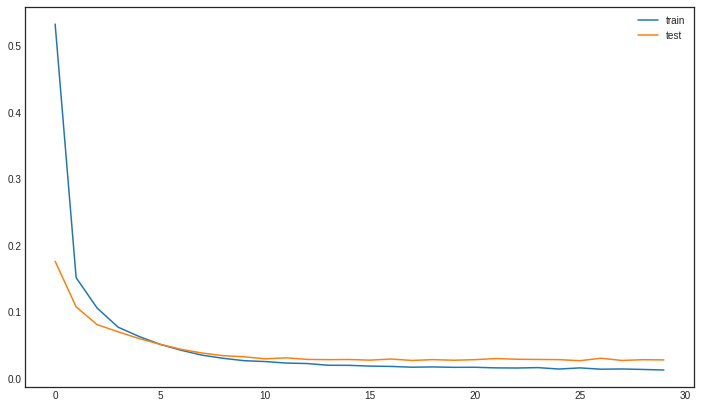

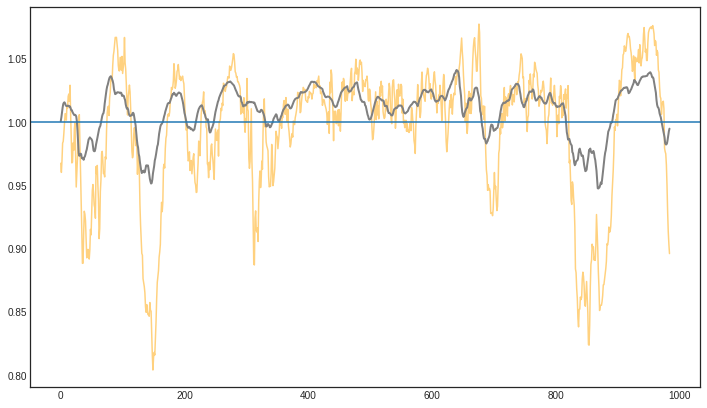

In [43]:
spine_color = '#808080'
grid_color = '#D3D3D3'

# Plot loss Error
#-------------------------------------------

fig = plt.figure(figsize=(12,7))

plt.style.use('seaborn-white')

# plot history
plt.plot(epoch_history.history['loss'], label='train')
plt.plot(epoch_history.history['val_loss'], label='test')
plt.legend()


# Model Evaluation - Confusion Matrix
#------------------------------------------

fig = plt.figure(figsize=(12,7))

y_pred = model.predict(test_x_subseq)
y_pred = y_pred.reshape(len(y_pred))
y_true = test_y_seq.reshape(len(y_pred))

plt.plot(y_pred, color='orange', alpha=0.5)
plt.plot(y_true, color='grey', lw=2)
plt.axhline(y=1)

pred_signal = np.where(y_pred - 1 > 0.005, 1, np.where(y_pred - 1 < 0, -1, 0))
true_signal = np.where(y_true - 1 > 0.005, 1, np.where(y_true - 1 < 0, -1, 0))

print(confusion_matrix(pred_signal, true_signal))
target_names = ['Below Cross', 'Cross', 'Above Cross']
print(classification_report(pred_signal, true_signal, target_names=target_names))


In [44]:
print(test_x_idx[3:9], test_y_idx[:6])
print(y_true[:6], y_pred[:6])
etf_range[4065:4070].head()

[4065, 4066, 4067, 4068, 4069, 4070] [4065, 4066, 4067, 4068, 4069, 4070]
[1.00077049 1.00382806 1.00785481 1.01146904 1.01429474 1.01532825] [0.9675109  0.9602654  0.96979356 0.9834585  0.9847701  0.99114454]


,in_range,signal,price,ema_s,ema_m,ema_l,ema_ratio,ema_ratio_s,adx,rsi
timestamp,,,,,,,,,,
2015-07-15,1,2,106.2328,105.165752,104.566194,104.485689,1.000770,1.005734,18.936304,58.174003
2015-07-16,1,2,107.7342,106.021901,105.018767,104.618282,1.003828,1.009552,19.050586,63.809659
2015-07-17,1,2,109.3222,107.122001,105.633543,104.810278,1.007855,1.014091,20.050497,68.624989
2015-07-20,1,2,109.6976,107.980534,106.214122,105.009761,1.011469,1.016631,21.346426,69.652810
2015-07-21,1,2,109.6302,108.530423,106.702134,105.198350,1.014295,1.017135,22.549790,69.214532


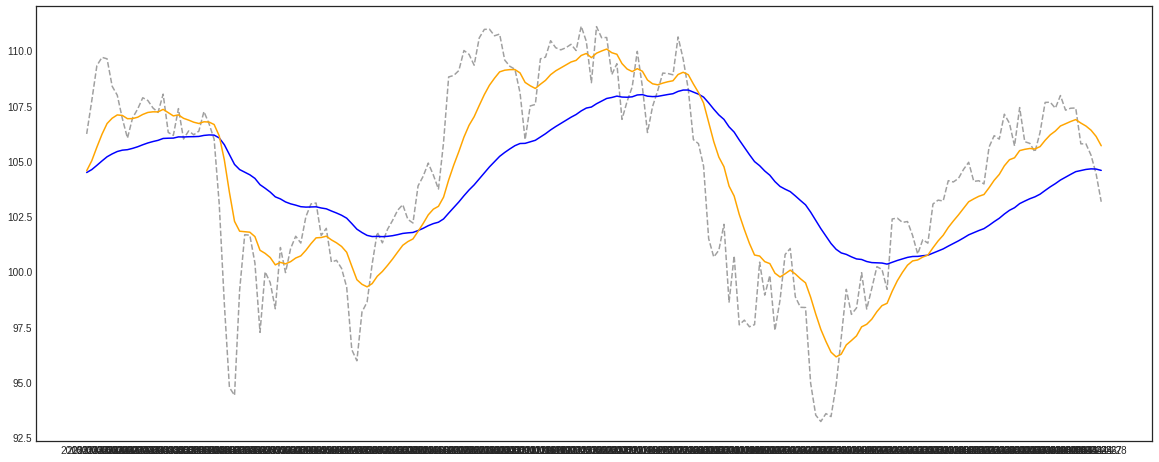

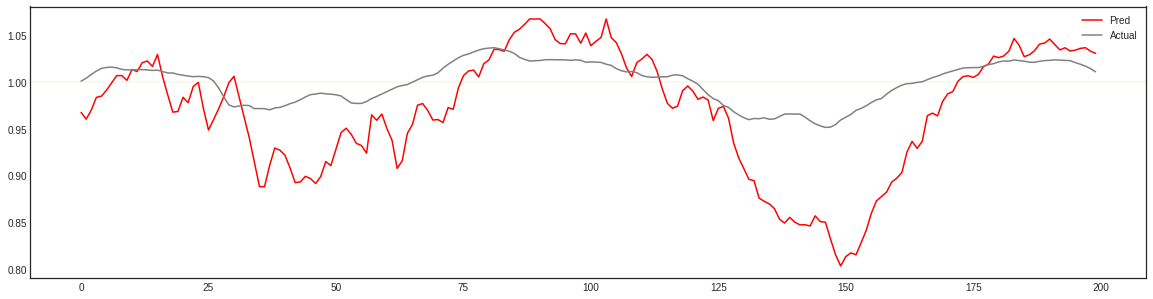

In [45]:

ref = 3
steps=200

start = test_x_idx[ref]
end = test_x_idx[ref+steps]


fig = plt.figure(figsize=(20,8))

#color = np.where((signal == 2) & (in_range == 0), 'g', np.where((signal == 1) & (in_range == 0), 'r', 'w'))
#color = np.where((signal == 2), 'g', np.where((signal == 1), 'r', 'w'))
#marker = np.where(signal == 2, '^', np.where(signal == 1, 'o', '.'))

plt.plot(etf_range.price[start:end], color = 'grey', alpha = 0.75, ls ='--')
plt.plot(etf_range.ema_l[start:end], color = 'blue')
plt.plot(etf_range.ema_m[start:end], color = 'orange')#plt.plot(etf_range.ema_s[start:end], color = 'violet')


#plt.scatter(etf_range[start:end].index, etf_range.price[start:end], marker = 'o', color=color)

fig = plt.figure(figsize=(20,5))

plt.plot(y_pred[0:steps], color = 'r', label='Pred')
plt.plot(y_true[0:steps], color = 'grey', label = 'Actual')
plt.axhspan(.999,1.001, facecolor = 'beige', alpha=0.5)
plt.legend()




### LSTM CNN Auto-Encoder



In [46]:
# CNN+LSTM - Single-Steps Encoder Output

# ************   BEST MODEL *****************

from numpy.random import seed
seed(2019)

from tensorflow import set_random_seed
set_random_seed(201907)

window = 3
dr = 0.2
adam = Adam(lr=0.0001)

n_features = train_x_seq.shape[2]
n_timesteps = train_x_seq.shape[1]
n_seqs = 2
n_steps = np.int(n_timesteps/n_seqs)

neurons = 64

'''
model.add(BatchNormalization())
model.add(TimeDistributed(Dense(1)))
'''

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(1))
model.add(LSTM(neurons, return_sequences=True))
#model.add(LSTM(36, return_sequences=True))
model.add(TimeDistributed(Dense(neurons)))
model.add(TimeDistributed(Dense(1)))

model.compile(loss=mae_loss, optimizer=adam)
print(model.summary())

n_epochs = 25
n_batch = 32

train_y_tseq = train_y_seq.reshape(train_y_seq.shape[0], 1, 1)
test_y_tseq = test_y_seq.reshape(test_y_seq.shape[0], 1, 1)

epoch_history = model.fit(train_x_seq, train_y_tseq, epochs=n_epochs, batch_size=n_batch, validation_data=(test_x_seq, test_y_tseq), verbose=2, shuffle=False)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 12, 64)            3520      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 320)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 64)             98560     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 64)            

[[224  40 115]
 [  2   1  40]
 [  8  10 545]]
              precision    recall  f1-score   support

 Below Cross       0.96      0.59      0.73       379
       Cross       0.02      0.02      0.02        43
 Above Cross       0.78      0.97      0.86       563

    accuracy                           0.78       985
   macro avg       0.59      0.53      0.54       985
weighted avg       0.81      0.78      0.78       985



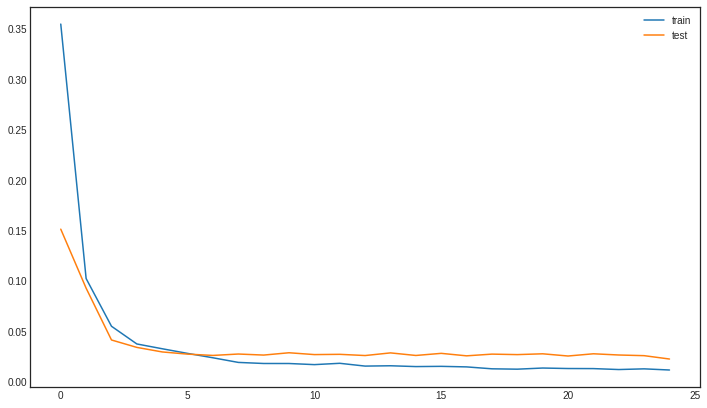

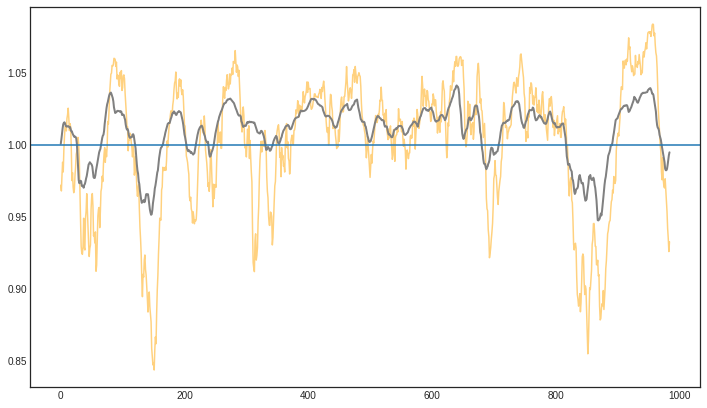

In [47]:
spine_color = '#808080'
grid_color = '#D3D3D3'

# Plot loss Error
#-------------------------------------------

fig = plt.figure(figsize=(12,7))

plt.style.use('seaborn-white')

# plot history
plt.plot(epoch_history.history['loss'], label='train')
plt.plot(epoch_history.history['val_loss'], label='test')
plt.legend()


# Model Evaluation - Confusion Matrix
#------------------------------------------

fig = plt.figure(figsize=(12,7))

y_pred = model.predict(test_x_seq)
y_pred = y_pred.reshape(len(y_pred))
y_true = test_y_tseq.reshape(len(y_pred))

plt.plot(y_pred, color='orange', alpha=0.5)
plt.plot(y_true, color='grey', lw=2)
plt.axhline(y=1)

pred_signal = np.where(y_pred - 1 > 0.005, 1, np.where(y_pred - 1 < 0, -1, 0))
true_signal = np.where(y_true - 1 > 0.005, 1, np.where(y_true - 1 < 0, -1, 0))

print(confusion_matrix(pred_signal, true_signal))
target_names = ['Below Cross', 'Cross', 'Above Cross']
print(classification_report(pred_signal, true_signal, target_names=target_names))



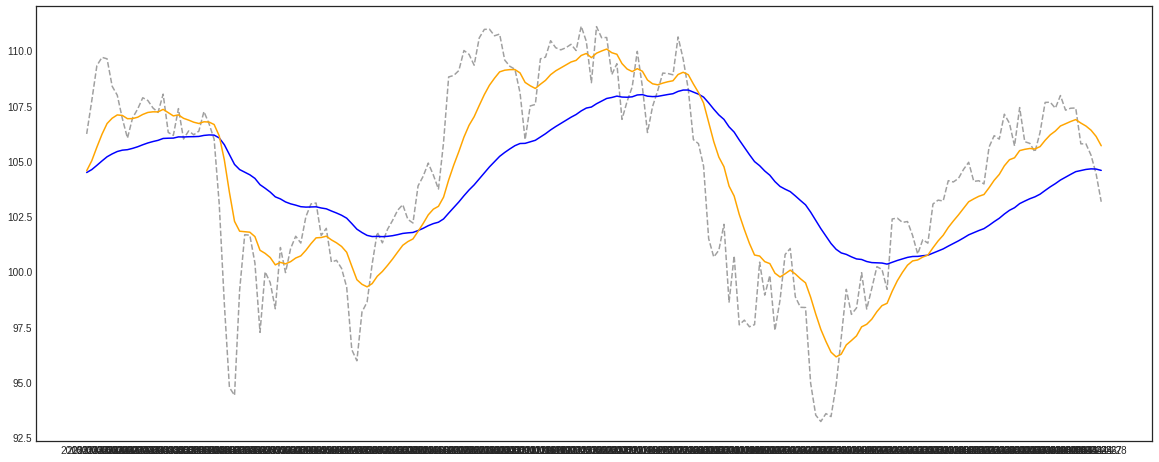

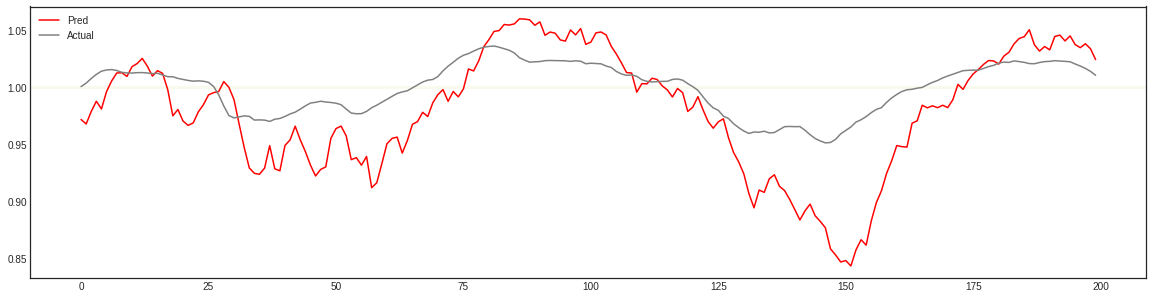

In [48]:

ref = 3
steps=200

start = test_x_idx[ref]
end = test_x_idx[ref+steps]


fig = plt.figure(figsize=(20,8))

#color = np.where((signal == 2) & (in_range == 0), 'g', np.where((signal == 1) & (in_range == 0), 'r', 'w'))
#color = np.where((signal == 2), 'g', np.where((signal == 1), 'r', 'w'))
#marker = np.where(signal == 2, '^', np.where(signal == 1, 'o', '.'))

plt.plot(etf_range.price[start:end], color = 'grey', alpha = 0.75, ls ='--')
plt.plot(etf_range.ema_l[start:end], color = 'blue')
plt.plot(etf_range.ema_m[start:end], color = 'orange')#plt.plot(etf_range.ema_s[start:end], color = 'violet')


#plt.scatter(etf_range[start:end].index, etf_range.price[start:end], marker = 'o', color=color)

fig = plt.figure(figsize=(20,5))

plt.plot(y_pred[0:steps], color = 'r', label='Pred')
plt.plot(y_true[0:steps], color = 'grey', label = 'Actual')
plt.axhspan(.999,1.001, facecolor = 'beige', alpha=0.5)
plt.legend()


8